**Imports**

In [1]:
import pathlib
import PIL
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import argparse
import os
import copy
from torch.utils.data import DataLoader
import pickle5 as pickle
from sklearn.neighbors import KNeighborsClassifier
import imutils
import cv2

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Paths**

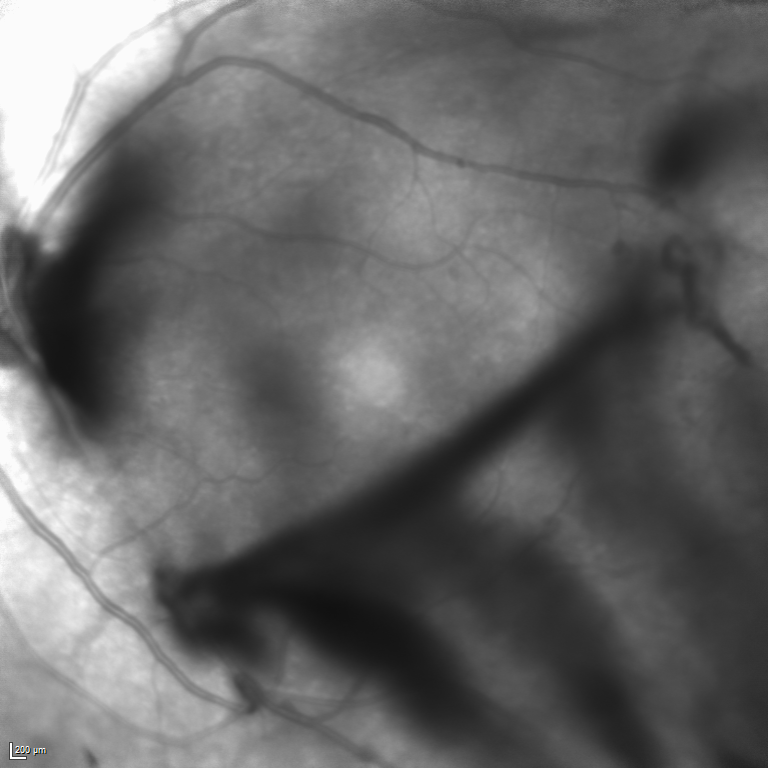

In [2]:
currDir = os.getcwd()
data_root = os.path.join(currDir, "OLIVES/Prime_FULL/")
annot_train_prime = os.path.join(currDir, "df_prime_train.csv")
annot_test_prime = os.path.join(currDir, "df_prime_test.csv")
testPath = os.path.join(data_root, "Prime_FULL/02-046/W104/OS/fundus_W104.tif")
PIL.Image.open(testPath)

**Data Loader**

In [3]:
LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)
imageSize = (224,224)

transform = transforms.Compose([
    transforms.Resize(size=imageSize),
    transforms.ToTensor(),
    normalize,
])
    
class OCTDataset(Dataset):
    def __init__(self, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(annot_train_prime)
        elif subset == 'test':
            self.annot = pd.read_csv(annot_test_prime)
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)
        
            

        return img, target

    def __len__(self):
        return len(self._labels)         



trainset = OCTDataset('train', transform=transform)
testset = OCTDataset('test', transform=transform)

**Get Item**

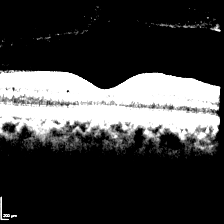

In [5]:
img, target = trainset.__getitem__(0)
npImage = img.numpy().reshape(imageSize)



imgTest = Image.fromarray(255*npImage)
imgTest.show()
trainSize = 24252
testSize = 7987
imageFlattenSize = imageSize[0]*imageSize[1]

**Gather Training Samples**

In [5]:

trainingSamples = [] 
trainingTargets = []

#for sample in range(len(trainset)):
    #(x,y) = trainset[sample]
    #xNP = np.resize(x.numpy(),imageFlattenSize)
    #trainingSamples.append(xNP)
    #trainingTargets.append(y)
    
for sample in range(len(trainset)):
    (x,y) = trainset[sample]
    xTensorFlat = torch.flatten(x)
    trainingSamples.append(xTensorFlat)
    trainingTargets.append(y)

print(len(trainingSamples))
print(len(trainingTargets))

24252
24252


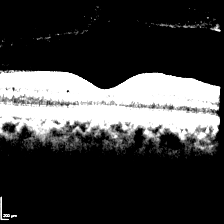

In [6]:
testSample = 255*trainingSamples[0].numpy().reshape(imageSize)
testImg = Image.fromarray(testSample)
testImg.show()

pickleTraining = open(os.path.join(currDir, "kmeansTrainingSamples.pickle"), "wb")
pickle.dump(trainingSamples, pickleTraining)
pickleTraining.close()

**Gather Validation Samples**

In [7]:
validationSamples = []
validationTargets = []
#for sample in range(len(testset)):
    #(x,y) =  testset[sample]
    #xNp = np.resize(x.numpy(), imageFlattenSize)
    #validationSamples.append(xNP.astype(np.float64))
   # validationTargets.append(y)
for sample in range(len(testset)):
    (x,y) = testset[sample]
    xTensorFlat = torch.flatten(x)
    validationSamples.append(xTensorFlat)
    validationTargets.append(y)
    
print(len(validationSamples))
    

7987


In [8]:
pickleValidation = open(os.path.join(currDir, "kmeansValidationSamples.pickle"), "wb")
pickle.dump(validationSamples, pickleValidation)
pickleValidation.close()

***Auto Encoder***

In [9]:
import torch.nn.functional as F

class MyMLPAE(torch.nn.Module):
    def __init__(self, hidden_size, inputSize):
        super(MyMLPAE, self).__init__()
        self.inputSize = inputSize
        
       # self.encoder = torch.nn.Sequential(
            #torch.nn.Linear(inputSize, 32768),
            #torch.nn.ReLU(inplace=True),
           # torch.nn.Linear(32768, hidden_size),
           # #torch.nn.ReLU(inplace=True)  
       # )
        
       # self.decoder = torch.nn.Sequential(
            #torch.nn.ReLU(inplace=True),
           # torch.nn.Linear(hidden_size, 32768),
            #torch.nn.ReLU(inplace=True), 
           # torch.nn.Linear(32768, inputSize),
       # )
    
        self.encoder = torch.nn.Linear(inputSize, hidden_size)
        self.decoder = torch.nn.Linear(hidden_size, inputSize)
        
    def forward(self, X):
            X = X.view(-1, self.inputSize)
            encoded_val = self.encoder(X)
             #print(encoded_val.shape)
            decoded_val = self.decoder(encoded_val)
            return decoded_val.view(X.shape[0], 1, self.inputSize)
            
    def encode(self, X):
            return self.encoder(X)
    

In [10]:
num_epochs = 50
net = MyMLPAE(50, imageFlattenSize).to(device)

#optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
print(trainingSamples[0].shape)

#training loop
net.train()
for epoch in range(num_epochs):
    for x_train in trainingSamples:
        net.zero_grad()
        
        x_train = x_train.to(device)
        out = net(x_train)
        loss = loss_fn(out, x_train)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch} | Train loss: {loss.item()}")
        

torch.Size([50176])


/home/dams/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50176])) that is different to the input size (torch.Size([1, 1, 50176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 0.5976257920265198
Epoch: 1 | Train loss: 1.1381862163543701
Epoch: 2 | Train loss: 1.3969218730926514
Epoch: 3 | Train loss: 2.9625308513641357
Epoch: 4 | Train loss: 0.20226319134235382
Epoch: 5 | Train loss: 0.40336480736732483
Epoch: 6 | Train loss: 0.8410767912864685
Epoch: 7 | Train loss: 2.702474355697632
Epoch: 8 | Train loss: 0.4769884943962097
Epoch: 9 | Train loss: 0.2225516140460968
Epoch: 10 | Train loss: 0.9323016405105591
Epoch: 11 | Train loss: 0.3094967305660248
Epoch: 12 | Train loss: 1.4426783323287964
Epoch: 13 | Train loss: 2.2092063426971436
Epoch: 14 | Train loss: 0.607293426990509
Epoch: 15 | Train loss: 0.32819071412086487
Epoch: 16 | Train loss: 0.34919431805610657
Epoch: 17 | Train loss: 0.3343470096588135
Epoch: 18 | Train loss: 0.2519407272338867
Epoch: 19 | Train loss: 0.45987677574157715
Epoch: 20 | Train loss: 0.3925580382347107
Epoch: 21 | Train loss: 0.5454181432723999
Epoch: 22 | Train loss: 0.3899962306022644
Epoch: 23 | Train 

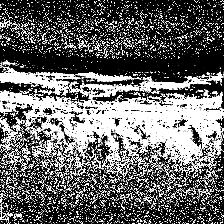

In [11]:
#look at reconstructed image
net.eval()
reconstructedImg = net(trainingSamples[0].to(device))
imgReconstructed = reconstructedImg.cpu().reshape(imageSize)
imgTest = Image.fromarray(255*imgReconstructed.detach().numpy())
imgTest.show()

In [12]:
#decode each training and validation img
trainData = []
testData = []

for x_train in trainingSamples:
    trainData.append(net.encode(x_train.to(device)).cpu().detach().numpy())

for x_test in validationSamples:
    testData.append(net.encode(x_test.to(device)).cpu().detach().numpy())
    
print(testData[0].shape)
print(trainData[0].shape)

(50,)
(50,)


**Run Training**

In [34]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(trainData, trainingTargets)

KNeighborsClassifier(n_neighbors=4)

Testing Phase

In [35]:
predicted = knn.predict(testData)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb819306b90>
Traceback (most recent call last):
  File "/home/dams/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dams/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dams/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dams/miniconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [36]:
from sklearn.metrics import accuracy_score

print(accuracy_score(predicted, validationTargets)) 

0.44710154000250407


**Confusion Matrix**

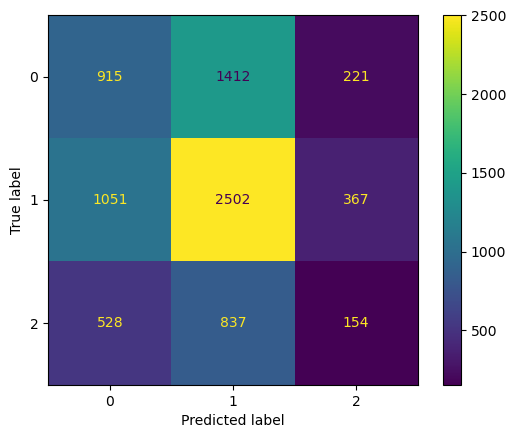

In [37]:
#confusion matrix
from sklearn import metrics
        
confusionMatrixVal = metrics.confusion_matrix(validationTargets, predicted)
cm_displayVal = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrixVal, display_labels = [0, 1, 2])
cm_displayVal.plot()


**Without AE**

In [7]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
validationSamples_noAE = []
validationTargets_noAE = []
trainSamples_noAE = []
trainTargets_noAE = []

for sample in range(len(testset)):
    (x,y) =  testset[sample]
    xNp = np.resize(x.numpy(), imageFlattenSize)
    validationSamples_noAE.append(xNp.astype(np.float64))
    validationTargets_noAE.append(y)
    
for sample in range(len(trainset)):
    (x,y) =  trainset[sample]
    xNp = np.resize(x.numpy(), imageFlattenSize)
    trainSamples_noAE.append(xNp.astype(np.float64))
    trainTargets_noAE.append(y)
    
print(len(validationSamples_noAE))
print(len(trainSamples_noAE))

7987
24252


In [1]:
#instantiate and fit
knn_noAE = KNeighborsClassifier(n_neighbors=3)
knn_noAE.fit(trainSamples_noAE, trainTargets_noAE)

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
#predict and produce confusion matrix
predicted_noAE = knn_noAE.predict(validationSamples_noAE)

print(accuracy_score(predicted_noAE, validationTargets_noAE)) 

confusionMatrixVal_noAE = metrics.confusion_matrix(validationTargets_noAE, predicted_noAE)
cm_displayVal_noAE = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrixVal_noAE, display_labels = [0, 1, 2])
cm_displayVal_noAE.plot()